In [6]:
import sys
import os

In [7]:
project_root = '/Users/tobiaspoulsen/Desktop/Bachelor/bachelorprojekt'
sys.path.append(project_root)


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from StandardAI.DataPreparation.DataCleaner.dataCleaner import DataCleaner
from StandardAI.DataPreparation.DataCleaner.duplicationHandler import DuplicationHandler
from StandardAI.DataPreparation.DataCleaner.dataTransformer import DataTransformer
from StandardAI.DataPreparation.DataTransformation.categoricalEncoder import CategoricalEncoder
from StandardAI.DataPreparation.DataReduction.dimensionalityReducer import DimensionalityReducer
from StandardAI.DataPreparation.DataTransformation.featureEngineer import FeatureEngineer
import spacy
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Initialize spaCy model
nlp = spacy.load('en_core_web_md')

class FeatureSelector:
    
    @staticmethod
    def select_k_best(df, target, k=10, score_func=f_classif):
        selector = SelectKBest(score_func=score_func, k=k)
        selector.fit(df, target)
        selected_columns = df.columns[selector.get_support()]
        return df[selected_columns]

    @staticmethod
    def select_by_model(df, target, model=None, n_features_to_select=10):
        if model is None:
            if is_classifier(target):
                model = RandomForestClassifier(n_estimators=100, random_state=42)
            else:
                model = RandomForestRegressor(n_estimators=100, random_state=42)
                
        model.fit(df, target)
        feature_importances = pd.Series(model.feature_importances_, index=df.columns)
        selected_columns = feature_importances.nlargest(n_features_to_select).index
        return df[selected_columns]

    @staticmethod
    def select_by_rfe(df, target, model=None, n_features_to_select=10):
        if model is None:
            model = LogisticRegression(solver='liblinear', random_state=42)
        
        rfe = RFE(model, n_features_to_select=n_features_to_select)
        rfe.fit(df, target)
        selected_columns = df.columns[rfe.support_]
        return df[selected_columns]

# Function to extract date parts
def extract_date_parts(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df[f'{date_col}_year'] = df[date_col].dt.year
    df[f'{date_col}_month'] = df[date_col].dt.month
    df[f'{date_col}_day'] = df[date_col].dt.day
    df.drop(columns=[date_col], inplace=True)
    return df

# Function to embed text columns using spaCy
def embed_column_spacy(df, column):
    print(f"Embedding column: {column}")
    embeddings = df[column].apply(lambda x: nlp(x).vector if isinstance(x, str) else np.zeros(nlp.vocab.vectors_length))
    embedded_df = pd.DataFrame(embeddings.tolist(), index=df.index).add_prefix(f'{column}_embed_')
    print(f"Finished embedding column: {column}, shape: {embedded_df.shape}")
    return embedded_df

# Timing function
def timeit(method):
    def timed(*args, **kwargs):
        start_time = time.time()
        result = method(*args, **kwargs)
        end_time = time.time()
        print(f"{method.__name__} took {end_time - start_time:.2f} seconds")
        return result
    return timed

@timeit
def main():
    start_total = time.time()
    
    print("Loading data...")
    df = pd.read_csv('movies.csv')

    label = "Popularity"

    # Identify non-numeric, non-categorical columns for embedding or one-hot encoding
    start = time.time()
    print("Identifying non-numeric columns...")
    non_numeric_columns = [col for col in df.columns if df[col].dtype == 'object' and col != label]

    # Embed text columns
    embedded_columns = []
    for col in non_numeric_columns:
        embedded_df = embed_column_spacy(df, col)
        df = pd.concat([df, embedded_df], axis=1)
        embedded_columns.extend(embedded_df.columns)
    df.drop(columns=non_numeric_columns, inplace=True)

    # Handle categorical data
    start = time.time()
    print("Handling categorical data...")
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    max_categories = 10
    high_cardinality_columns = []

    if categorical_columns:
        for col in categorical_columns:
            if df[col].nunique(dropna=True) > max_categories:  # Handle NaN values
                high_cardinality_columns.append(col)
            else:
                df, encoders, onehot_encoded_cols = CategoricalEncoder.fit_transform_onehot_encoding(df, [col], max_categories=max_categories)
                embedded_columns.extend(onehot_encoded_cols)

    if high_cardinality_columns:
        df, label_encoders = CategoricalEncoder.fit_transform_label_encoding(df, high_cardinality_columns)
    print(f"Categorical data handling took {time.time() - start:.2f} seconds")

    # Clean the data
    start = time.time()
    print("Cleaning data...")
    cleaner = DataCleaner()
    cleaned_data = cleaner.smart_clean_data(df, label, missing_threshold=0.3, correlation_threshold=0.5)
    print(f"Data cleaning took {time.time() - start:.2f} seconds")

    # Handle duplicates
    start = time.time()
    print("Handling duplicates...")
    handler = DuplicationHandler()
    cleaned_data = handler.remove_duplicates(cleaned_data)
    print(f"Duplicate handling took {time.time() - start:.2f} seconds")

    # Data transformation
    start = time.time()
    print("Transforming data...")
    transformer = DataTransformer()
    numeric_columns = cleaned_data.select_dtypes(include=[np.number]).columns.tolist()
    if label in numeric_columns:
        numeric_columns.remove(label)

    for column in numeric_columns:
        skewness = cleaned_data[column].skew()
        if abs(skewness) > 0.5:
            cleaned_data = transformer.apply_log_transformation(cleaned_data, column)

    for column in numeric_columns:
        Q1 = cleaned_data[column].quantile(0.25)
        Q3 = cleaned_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((cleaned_data[column] < lower_bound) | (cleaned_data[column] > upper_bound)).sum()
        if outliers > 0:
            cleaned_data = transformer.impute_outliers(cleaned_data, column, method='median')

        cleaned_data = transformer.winsorize_data(cleaned_data, column, limits=(0.05, 0.05))
    print(f"Data transformation took {time.time() - start:.2f} seconds")

    # Remove columns that are entirely NaN
    cleaned_data = cleaned_data.dropna(axis=1, how='all')

    # Ensure consistent columns before imputation
    consistent_columns = cleaned_data.columns.tolist()

    # Impute missing values
    start = time.time()
    print("Imputing missing values...")
    imputer = SimpleImputer(strategy='mean')
    transformed_data = imputer.fit_transform(cleaned_data)
    transformed_df = pd.DataFrame(transformed_data, columns=consistent_columns)
    print(f"Missing value imputation took {time.time() - start:.2f} seconds")

    # Ensure no NaN values are present
    if transformed_df.isnull().values.any():
        print("NaN values found in the data after imputation. Performing imputation again.")
        transformed_df = pd.DataFrame(imputer.fit_transform(transformed_df), columns=consistent_columns)

    # Feature engineering
    start = time.time()
    print("Engineering features...")
    feature_engineer = FeatureEngineer()
    
    if 'feature1' in transformed_df.columns and 'feature2' in transformed_df.columns:
        transformed_df = feature_engineer.add_interaction_feature(transformed_df, 'feature1', 'feature2', 'feature1_x_feature2')
    
    if 'release_date' in transformed_df.columns:
        transformed_df = feature_engineer.add_date_parts(transformed_df, 'release_date')
    
    if 'price' in transformed_df.columns:
        transformed_df = feature_engineer.add_rolling_features(transformed_df, 'price', window_size=2)
    
    print(f"Feature engineering took {time.time() - start:.2f} seconds")

    # Ensure no NaN values before feature selection
    if transformed_df.isnull().values.any():
        print("NaN values found in the data before feature selection. Performing imputation again.")
        transformed_df = pd.DataFrame(imputer.fit_transform(transformed_df), columns=consistent_columns)

    # Feature selection using FeatureSelector class
    start = time.time()
    print("Selecting features...")
    X = transformed_df.drop(columns=[label])
    y = transformed_df[label]
    
    selected_df = FeatureSelector.select_by_rfe(X, y, model=LinearRegression(), n_features_to_select=10)
    selected_df[label] = transformed_df[label]
    print(f"Feature selection took {time.time() - start:.2f} seconds")

    # Dimensionality reduction using PCA
    start = time.time()
    print("Reducing dimensionality...")
    reducer = DimensionalityReducer()
    reduced_df, pca_model, scaler = reducer.fit_transform_pca(selected_df.drop(columns=[label]), n_components=5)
    reduced_df[label] = selected_df[label]
    print(f"Dimensionality reduction took {time.time() - start:.2f} seconds")

    # Split the data into train and test sets
    print("Splitting data into train and test sets...")
    X = reduced_df.drop(columns=[label])
    y = reduced_df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the neural network model
    def create_nn_model(input_dim):
        model = Sequential()
        model.add(Dense(64, input_dim=input_dim, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1))  # Output layer for regression
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    # Create and train the neural network model
    nn_model = create_nn_model(X_train.shape[1])
    nn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

    # Evaluate the neural network model
    y_pred_nn = nn_model.predict(X_test)
    mse_nn = mean_squared_error(y_test, y_pred_nn)
    r2_nn = r2_score(y_test, y_pred_nn)

    print(f"\nNeural Network Model Performance:")
    print(f"Mean Squared Error: {mse_nn}")
    print(f"R^2 Score: {r2_nn}")

    # Evaluate the model using cross-validation
    def evaluate_model(model, X, y):
        scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_squared_error')  # Reduced to 3 folds
        mse_scores = -scores
        mean_mse = np.mean(mse_scores)
        std_mse = np.std(mse_scores)
        return mean_mse, std_mse

    # Train and evaluate a Linear Regression model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred = lin_reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    cv_mse, cv_std_mse = evaluate_model(lin_reg, X, y)

    print(f"\nLinear Regression Model Performance:")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print(f"Cross-Validated MSE: {cv_mse} (±{cv_std_mse})")

    # Train and evaluate a Ridge Regression model
    ridge_reg = Ridge(alpha=1.0)
    ridge_reg.fit(X_train, y_train)
    y_pred_ridge = ridge_reg.predict(X_test)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    r2_ridge = r2_score(y_test, y_pred_ridge)
    cv_mse_ridge, cv_std_mse_ridge = evaluate_model(ridge_reg, X, y)

    print(f"\nRidge Regression Model Performance:")
    print(f"Mean Squared Error: {mse_ridge}")
    print(f"R^2 Score: {r2_ridge}")
    print(f"Cross-Validated MSE: {cv_mse_ridge} (±{cv_std_mse_ridge})")

    # Train and evaluate a RandomForest Regressor model
    forest_reg = RandomForestRegressor(random_state=42, n_estimators=50)  # Reduced to 50 estimators
    forest_reg.fit(X_train, y_train)
    y_pred_forest = forest_reg.predict(X_test)
    mse_forest = mean_squared_error(y_test, y_pred_forest)
    r2_forest = r2_score(y_test, y_pred_forest)
    cv_mse_forest, cv_std_mse_forest = evaluate_model(forest_reg, X, y)

    print(f"\nRandom Forest Regressor Model Performance:")
    print(f"Mean Squared Error: {mse_forest}")
    print(f"R^2 Score: {r2_forest}")
    print(f"Cross-Validated MSE: {cv_mse_forest} (±{cv_std_mse_forest})")

    # Train and evaluate a Gradient Boosting Regressor model
    gbr_reg = GradientBoostingRegressor(random_state=42, n_estimators=50)  # Reduced to 50 estimators
    gbr_reg.fit(X_train, y_train)
    y_pred_gbr = gbr_reg.predict(X_test)
    mse_gbr = mean_squared_error(y_test, y_pred_gbr)
    r2_gbr = r2_score(y_test, y_pred_gbr)
    cv_mse_gbr, cv_std_mse_gbr = evaluate_model(gbr_reg, X, y)

    print(f"\nGradient Boosting Regressor Model Performancea:")
    print(f"Mean Squared Error: {mse_gbr}")
    print(f"R^2 Score: {r2_gbr}")
    print(f"Cross-Validated MSE: {cv_mse_gbr} (±{cv_std_mse_gbr})")

# Run the main function
main()


Loading data...
Identifying non-numeric columns...
Embedding column: Name
Finished embedding column: Name, shape: (1925, 300)
Embedding column: Original_name
Finished embedding column: Original_name, shape: (1925, 300)
Embedding column: First_air_date
Finished embedding column: First_air_date, shape: (1925, 300)
Handling categorical data...
Categorical data handling took 0.00 seconds
Cleaning data...
Data cleaning took 4.50 seconds
Handling duplicates...
Duplicate handling took 0.19 seconds
Transforming data...


/opt/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/opt/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/opt/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/opt/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/numpy/lib/function

Data transformation took 7.04 seconds
Imputing missing values...
Missing value imputation took 0.05 seconds
Engineering features...
Feature engineering took 0.00 seconds
Selecting features...


/var/folders/mv/1wspd8ss21x8drphht5pcly80000gn/T/ipykernel_60994/3698611332.py:214: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df[label] = transformed_df[label]


Feature selection took 1449.24 seconds
Reducing dimensionality...
Dimensionality reduction took 0.09 seconds
Splitting data into train and test sets...


2024-05-28 21:15:50.902553: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-28 21:15:50.904100: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-05-28 21:15:52.965030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-28 21:15:53.052865: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


39/39 [==============================] - 3s 33ms/step - loss: 60342.5977 - val_loss: 109178.3750
Epoch 2/100
 1/39 [..............................] - ETA: 0s - loss: 193357.8906

2024-05-28 21:15:55.206999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 1s 17ms/step - loss: 59922.7461 - val_loss: 108485.9062
Epoch 3/100
39/39 [==============================] - 1s 20ms/step - loss: 59065.5664 - val_loss: 107139.5703
Epoch 4/100
39/39 [==============================] - 1s 16ms/step - loss: 57350.2422 - val_loss: 104289.3047
Epoch 5/100
39/39 [==============================] - 1s 18ms/step - loss: 54392.6484 - val_loss: 100114.1719
Epoch 6/100
39/39 [==============================] - 1s 26ms/step - loss: 50272.3711 - val_loss: 94694.8516
Epoch 7/100
39/39 [==============================] - 1s 19ms/step - loss: 45822.4258 - val_loss: 89292.8125
Epoch 8/100
39/39 [==============================] - 1s 16ms/step - loss: 42052.0352 - val_loss: 85048.4062
Epoch 9/100
39/39 [==============================] - 1s 16ms/step - loss: 40095.3945 - val_loss: 82483.8984
Epoch 10/100
39/39 [==============================] - 1s 18ms/step - loss: 38887.5469 - val_loss: 81088.8438
Epoch 11/100
39/39 [===============

2024-05-28 21:17:09.512667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 23ms/step

Neural Network Model Performance:
Mean Squared Error: 32042.58857982769
R^2 Score: 0.05096680172514889

Linear Regression Model Performance:
Mean Squared Error: 32323.642272693916
R^2 Score: 0.0426425902038704
Cross-Validated MSE: 41551.3990946224 (±10993.056737248553)

Ridge Regression Model Performance:
Mean Squared Error: 32322.342199079285
R^2 Score: 0.04268109561417488
Cross-Validated MSE: 41551.28060043039 (±10992.63464231014)

Random Forest Regressor Model Performance:
Mean Squared Error: 34319.343388586945
R^2 Score: -0.016465824464256817
Cross-Validated MSE: 47357.2262296197 (±12132.929691338233)

Gradient Boosting Regressor Model Performancea:
Mean Squared Error: 32945.90517658038
R^2 Score: 0.02421248889130223
Cross-Validated MSE: 54712.434368034454 (±17280.783677955482)
main took 1569.54 seconds


In [3]:
df.info

<bound method DataFrame.info of     PassengerId  Survived  Pclass        Age  SibSp  Parch     Fare  \
0             1         0       3  22.000000      1      0   7.2500   
1             2         1       1  38.000000      1      0  71.2833   
2             3         1       3  26.000000      0      0   7.9250   
3             4         1       1  35.000000      1      0  53.1000   
4             5         0       3  35.000000      0      0   8.0500   
..          ...       ...     ...        ...    ...    ...      ...   
95           96         0       3  27.465769      0      0   8.0500   
96           97         0       1  71.000000      0      0  34.6542   
97           98         1       1  23.000000      0      1  63.3583   
98           99         1       2  34.000000      0      1  23.0000   
99          100         0       2  34.000000      1      0  26.0000   

    Name_embed_0  Name_embed_1  Name_embed_2  ...  Cabin_embed_293  \
0      -2.816900     -1.483510     -0.552356 


Linear Regression Model Performance:
CV Mean Squared Error: 41769.75648046454
CV R^2 Score: 0.1345531004118567
Test Mean Squared Error: 29040.810431387818
Test R^2 Score: 0.1398730743762574

Ridge Regression Model Performance:
CV Mean Squared Error: 41756.02096436695
CV R^2 Score: 0.13495801569082527
Test Mean Squared Error: 29048.72398342647
Test R^2 Score: 0.13963869182684985

Random Forest Regressor Model Performance:
CV Mean Squared Error: 40866.99468871588
CV R^2 Score: 0.10205904750223946
Test Mean Squared Error: 29312.950939456307
Test R^2 Score: 0.1318128523967207

Gradient Boosting Regressor Model Performance:
CV Mean Squared Error: 40011.972110073824
CV R^2 Score: 0.1393760088403592
Test Mean Squared Error: 28376.282862652897
Test R^2 Score: 0.15955496500526056


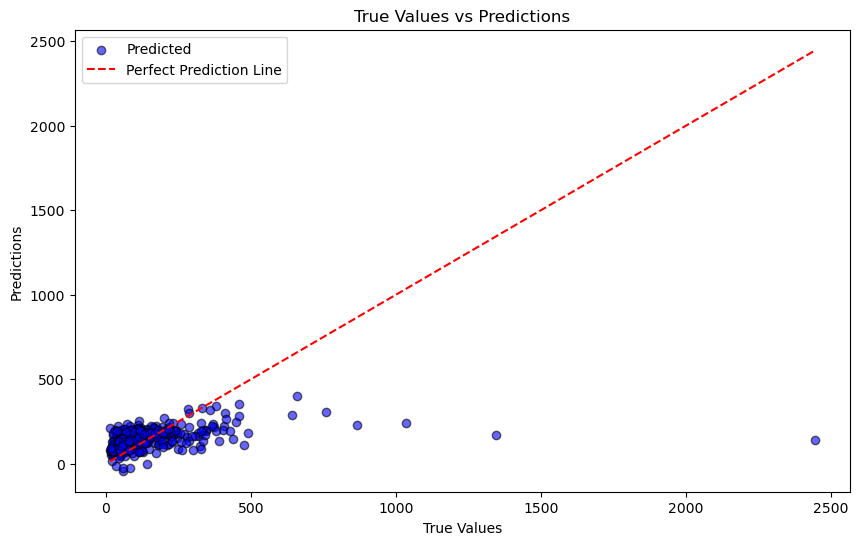

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Load your dataset
df = pd.read_csv('movies.csv')

# Define the label (target variable)
label = "Popularity"

# Handle missing values
df = df.dropna(subset=[label])  # Drop rows where the label is missing
df = df.fillna(df.mean(numeric_only=True))  # Fill missing values in numeric columns with the mean

# Drop non-numeric columns
non_numeric_cols = df.select_dtypes(include=['object']).columns
df = df.drop(columns=non_numeric_cols)

# Split the data into features (X) and target (y)
X = df.drop(columns=[label])
y = df[label]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate models using cross-validation
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest Regressor": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42, n_estimators=100)
}

results = {}

for name, model in models.items():
    cv_mse = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        "CV Mean Squared Error": cv_mse.mean(),
        "CV R^2 Score": cv_r2.mean(),
        "Test Mean Squared Error": mse,
        "Test R^2 Score": r2
    }

for name, metrics in results.items():
    print(f"\n{name} Model Performance:")
    print(f"CV Mean Squared Error: {metrics['CV Mean Squared Error']}")
    print(f"CV R^2 Score: {metrics['CV R^2 Score']}")
    print(f"Test Mean Squared Error: {metrics['Test Mean Squared Error']}")
    print(f"Test R^2 Score: {metrics['Test R^2 Score']}")

# Plot the true vs predicted values for the best model (assuming Linear Regression for simplicity)
best_model = LinearRegression()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolor='k', facecolor='blue', alpha=0.6, label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.legend()
plt.show()


In [34]:
pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 76.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.4 MB/s eta 0:00:00
  Created wheel for gensim: filename=gensim-4.3.2-cp312-cp312-macosx_10_9_x86_64.whl size=23963916 sha256=ce616a6665291c1f5403740f3642828925fb442b29bd6eb2c9c5b99d9cd386a6
  Stored in directory: /Users/tobiaspoulsen/Library/Caches/pip/wheels/50/c0/ac/7bb08954bc59d390c848b480a3fc5eec68c14bc77bf334d624
Successfully built gensim
Note: you may need to restart the kernel to use updated packages.


In [4]:
# First, make sure to install the required packages
#!pip install spacy
#!python -m spacy download en_core_web_md

# Importing the necessary libraries
import spacy

# Define the WordEmbedder class
class WordEmbedder:
    def __init__(self, model_name='en_core_web_md'):
        self.model_name = model_name
        self.model = self.load_model()

    def load_model(self):
        print(f"Loading pre-trained model '{self.model_name}'...")
        model = spacy.load(self.model_name)
        print("Model loaded successfully!")
        return model

    def embed_word(self, word):
        return self.model(word).vector

    def embed_words(self, words):
        return {word: self.embed_word(word) for word in words}

# Create an instance of the WordEmbedder class
embedder = WordEmbedder()

# Define a list of words to embed
words = ["king", "queen", "man", "woman"]

# Get the embeddings for the words
embeddings = embedder.embed_words(words)

# Display the embeddings
for word, embedding in embeddings.items():
    print(f"Embedding for '{word}': {embedding[:10]}...")  # Display first 10 values for brevity


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.7.1/en_core_web_md-3.7.1-py3-none-any.whl (42.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
Loading pre-trained model 'en_core_web_md'...
Model loaded successfully!
Embedding for 'king': [-0.11296 -4.1865  -1.8453   0.30781  2.4956   0.96267 -1.8161   4.4655
 -2.821    0.9709 ]...
Embedding for 'queen': [ 2.167    0.29991 -3.1277  -2.7817  -0.26743  3.0804  -2.6528   0.59692
  0.12359  4.8586 ]...
Embedding for 'man': [-1.2867  -0.7992  -2.092   -0.77679 -2.5057   2.7123   0.59127  3.2927
 -1.5826   6.4515 ]...
Embedding for 'woman': [ 0.76548  1.0758  -1.633   -2.998   -0.82636  0.2095  -1.4199   3.8564
 -1.207    7.5657 ]...


In [9]:
pip uninstall scipy numpy gensim -y

Found existing installation: scipy 1.13.0
Uninstalling scipy-1.13.0:
  Successfully uninstalled scipy-1.13.0
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: gensim 4.3.2
Uninstalling gensim-4.3.2:
  Successfully uninstalled gensim-4.3.2
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip cache purge


Files removed: 2027
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 61.9 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.4.2 requires scipy>=1.6.0, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 63.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 67.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gensim: filename=gensim-4.3.2-cp312-cp312-macosx_10_9_x86_64.whl size=23963916 sha256=802f13ca6610acf9ab95b97e2a92176ce24ebc02248d9c98ecd23cd66a67e4be
  Stored in directory: /Users/tobiaspoulsen/Library/Caches/pip/wheels/50/c0/ac/7bb08954bc59d390c848b480a3fc5eec68c14bc77bf334d624
Successfully built gensim
Note: you may need to restart the kernel to use updated packages.
